In [1]:
%matplotlib inline

import os
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageFont, ImageDraw, ImageEnhance

# Data generation

## Generation config

In [2]:
characters = " ',-%0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyzæøåÆØÅ"
image_count = 30000
character_size = (16, 32)
grid_size = (40, 1)

image_size = character_size[0] * grid_size[0], character_size[1] * grid_size[1]

## Fonts

In [3]:
# https://www.wfonts.com/download/data/2016/05/13/lucida-console/lucida%20console.ttf'
# https://www.wfonts.com/download/data/2016/07/23/hack/Hack-Bold.ttf'
# https://www.wfonts.com/download/data/2016/07/23/hack/Hack-Regular.ttf'
# https://www.wfonts.com/download/data/2018/01/07/nairi/Nairi-Normal.ttf'

FONT_NAMES = sorted(a for a in os.listdir('fonts') if 'ttf' in a)
FONT_Y_OFFSET = [-7, -8, -4 , -12]

print(' dY  Font')
print('\n'.join('%s  %s' % (str(dy).rjust(3), name) for dy, name in zip(FONT_Y_OFFSET, FONT_NAMES)))

fonts = [ImageFont.truetype(os.path.join('fonts', font), character_size[1]+12) for font in FONT_NAMES]

 dY  Font
 -7  hack-bold.ttf
 -8  hack-regular.ttf
 -4  lucida-console.ttf
-12  nairi-normal.ttf


## Help functions

In [4]:
def add_noise(img, low=-80, high=80):
    noise = np.random.uniform(low, high, img.shape)
    new_img = np.uint8(np.clip(img + noise, 0, 255))
    return new_img

## Generate images

In [5]:
import shutil
from tqdm import tqdm_notebook

images = []
labels = []

for n in tqdm_notebook(range(image_count)):
    strech = 1.3 + random.random() * 1
    strech_size = int(image_size[0] * strech), image_size[1]

    img = Image.new('L', strech_size, 'white')
    draw = ImageDraw.Draw(img)
    label = np.zeros((grid_size[1], grid_size[0]))
    
    for x in range(grid_size[0]):
        for y in range(grid_size[1]):
            if True:# random.random() < 0.7:
                char_index = random.randint(0, len(characters)-1)
                font_index = random.randint(0, len(fonts)-1)
                label[y][x] = char_index
                r = character_size[0] // 4, character_size[1] // 10
                rx, ry = random.randint(-r[0], r[0]), random.randint(-r[1], r[1])
                draw.text((x*strech*character_size[0] + rx, y*character_size[1] + ry + FONT_Y_OFFSET[font_index]), characters[char_index], 'black', font=fonts[font_index])
    
    downscale = 1 + 2 * random.random()
    img = img.resize((int(image_size[0] / downscale), int(image_size[1] / downscale)))
    img = img.resize(image_size, Image.ANTIALIAS)
    np_img = np.asarray(img)
    np_img = add_noise(np_img)
    np_img[np_img > 120] = 255
    
    images.append(np_img)
    labels.append(label)

np.save('images.npy', np.array(images))
np.save('labels.npy', np.array(labels))

# Load data

Images shape: (30000, 32, 640, 1)
Labels shape: (30000, 1, 40, 1)


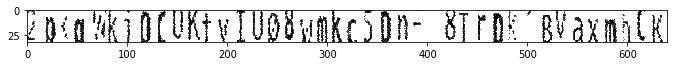

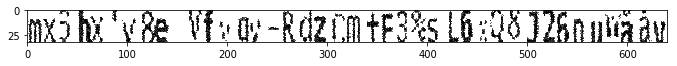

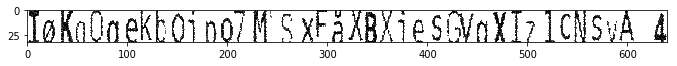

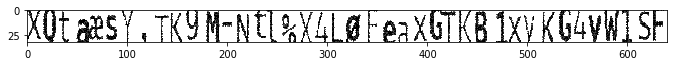

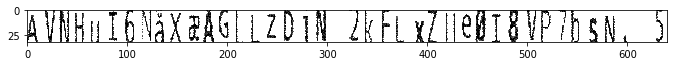

In [6]:
x_train = np.load('images.npy')
y_train = np.load('labels.npy')

for i in range(5):
    fig, ax = plt.subplots(figsize=(11.47, 11.47))
    plt.imshow(Image.fromarray(x_train[i], 'L'))

x_train = x_train.reshape((*x_train.shape, 1))
y_train = y_train.reshape((*y_train.shape, 1))

print('Images shape:', x_train.shape)
print('Labels shape:', y_train.shape)

# Model

In [7]:
import tensorflow as tf
from keras_tqdm import TQDMNotebookCallback

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (8, 4), strides=(2, 1), padding='same', activation='relu', input_shape=x_train.shape[1:]),
    tf.keras.layers.Conv2D(128, (8, 4), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(256, (2, 2), strides=(2, 2), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(256, (2, 2), strides=(1, 1), padding='same', activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(len(characters), (2, 2), strides=(2, 2), activation='softmax'),
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()
model.fit(x_train, y_train, epochs=20, verbose=0, callbacks=[TQDMNotebookCallback()])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 640, 64)       2112      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 320, 128)       262272    
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 160, 256)       524544    
_________________________________________________________________
dropout (Dropout)            (None, 4, 160, 256)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 80, 256)        262400    
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 80, 256)        262400    
_________________________________________________________________
dropout_1 (Dropout)          (None, 2, 80, 256)        0         
__________

# Results
## Help functions

In [8]:
THRESHOLD = 100
MIN_LINE_PIXELS = 18
MAX_LINE_PIXELS = 24
MAX_ROTATION = 5
ROTATION_INTERVAL = 0.05
SPACE_HEIGHT = 4

def remove_top(img, t=None, f=np.min):
    if t is None:
        t = THRESHOLD
    np_img = np.asarray(img)
    height, width = np_img.shape
    for i in range(height):
        if f(np_img[i]) < t:
            return img.crop((0, i, width, height))

def remove_bottom(img, t=None, f=np.min):
    if t is None:
        t = THRESHOLD
    np_img = np.asarray(img)
    height, width = np_img.shape
    for i in range(height-1, -1, -1):
        if f(np_img[i]) < t:
            return img.crop((0, 0, width, i))

def rotate(img):
    rotated = []
    angles = []
    for i in range(int(2 * MAX_ROTATION / ROTATION_INTERVAL + 1)):
        angle = -MAX_ROTATION + i * ROTATION_INTERVAL
        angles.append(angle)
        rotated.append(np.asarray(img.rotate(angle)))
    best_rotation_index = np.argmax([max([np.sum(np_img[i:i+SPACE_HEIGHT]) for i in range(MIN_LINE_PIXELS, MAX_LINE_PIXELS)]) for np_img in rotated])
    
    img = img.convert('RGBA').rotate(angles[best_rotation_index])
    back = Image.new('RGBA', img.size, 'white')
    back.paste(img, mask=img)
    img = back.convert('L')
    return img

def get_lines(img):
    img = remove_top(rotate(remove_top(img)))
    try:
        while True:
            np_img = np.asarray(img)
            y_crop = MIN_LINE_PIXELS + np.argmax([np.sum(np_img[i:i+SPACE_HEIGHT]) for i in range(MIN_LINE_PIXELS, MAX_LINE_PIXELS)])
            line_img = img.crop((0, 0, img.width, y_crop))
            
            np_line_img = np.asarray(line_img)
            height, width = np_line_img.shape
            for i in range(width):
                if np.min(np_img[:,i]) < THRESHOLD:
                    left = i
                    break
            for i in range(width-1, -1, -1):
                if np.min(np_img[:,i]) < THRESHOLD:
                    right = i
                    break
            yield line_img.crop((left, 0, right, line_img.height))
            
            img = remove_top(rotate(remove_top(img.crop((0, y_crop + SPACE_HEIGHT // 4, img.width, img.height)))))
    except:
        pass

def remove_bg(np_img):
    np_img[np_img > 90] = 255
    return np_img


## Predict

In [9]:
def predict_line(prediction):
    prediction = model.predict([[prediction]])[0]
    classes = np.argmax(prediction, axis=-1)
    output = ''
    for i, row in enumerate(classes):
        for col in row:
            output += characters[col]
        if i < len(classes) - 1:
            output += '\n'
    return output

def predict_image(path, show_lines=False):
    output = ''
    img = Image.open(path).convert('L')
    w, h = img.size
    scale = 500 / w
    img = img.resize((int(scale*w), int(scale*h)), Image.ANTIALIAS)
    avg = np.mean(np.asarray(img))
    img = ImageEnhance.Brightness(img).enhance(1+(255-avg) / 255)
    img = ImageEnhance.Contrast(img).enhance(1.5+(255-avg) / 255)
    for img in get_lines(img):
        img = img.resize(image_size)
        contrast = ImageEnhance.Contrast(img).enhance(4)
        np_img = np.asarray(contrast).copy()
        np_img = remove_bg(np_img)
        img = remove_top(remove_bottom(Image.fromarray(np_img), 240, np.mean), 240, np.mean)
        img = img.resize(image_size)
        np_img = np.asarray(img).copy()
        if show_lines:
            fig, ax = plt.subplots(figsize=(11.47, 11.47))
            plt.imshow(img)
        np_img = np_img.reshape((*np_img.shape, 1))
        output += predict_line(np_img) + '\n'

    return output

## Improve with word dict

In [10]:
# Norwegian dictionary: http://www2.scrabbleforbundet.no/?p=3885

def char_diff(a, b):
    if a == b:
        return 0
    equal = ('o0q', 'a4')
    for e in equal:
        if a in e and b in e:
            return 0.1
    close = ('it',)
    for c in close:
        if a in c and b in c:
            return 0.5
    return 1

with open('words.txt', 'r', encoding='utf-8') as f:
    words = [a.strip() for a in f.readlines()]

def check_word(word):
    rep = {
        '15K': '15%',
        '15X': '15%',
        '15V': '15%',
        '25K': '25%',
        '25X': '25%',
        '25V': '25%',
        'km': 'kr',
        'kn': 'kr'
    }
    if word in rep:
        return rep[word]
    if ',' in word:
        return word.replace('Q', '0').replace('U', '0').replace('D', '0').replace('O', '0').replace('b', '6').replace('o', '0')
    l = len(word)
    if l < 3:
        return word
    diffs = []
    for w in words:
        if len(w) == l:
            diff = np.sum([char_diff(word[i].lower(), w[i]) for i in range(l)])
            if diff <= l / 2:
                diffs.append((diff, w))
    if diffs:
        i = np.argmin(np.array(diffs)[:,0])
        best_word = diffs[i][1]
        #print(word, '=>', best_word)
        upper = np.sum([word[i].isupper() for i in range(l)]) / l > 0.5
        return ''.join([best_word[i].upper() if upper else best_word[i] for i in range(l)])
    return word

# Results

KJELDsBERGÆFDLTER         U5%      25,OO
KOELDSBER0 FIUIER         16%      26,O0
KOELOSBER0 FILTER         15%      26,OO
KJELQSBER0ÆFILTER         16%      25,OO
Kdøldøparg 4 fon 75,-             -25,OO
PÆRER                     15K      72,6O
3,64Bcg xlqr V9J9D                      
PAPPTALLERKEN,220M        25%      24,9O
KAFFEBE0ERlMZdWNK        D26%      32,3O
BÅNANER                   I5%      79,67
0,50BkQ x kr 2Iu9O                      
JORDBØR                  CU0Å     139,OO
7 KlK' 19,9D                            
BÆREPQSE                  35K       l,6Q
BÆREPD9E                 D20%       1,60

KVELDSPERMISJONER         U5%      25,00
KJELDSBERG ETUIER         16%      26,00
KJELDSBERG FILTER         15%      26,00
KJELQSBER0ÆFILTER         16%      25,00
kjeldsberg 4 fon 75,-             -25,00
PÆRER                     15%      72,60
3,64Bcg flor V9J9D                      
PAPPTALLERKEN,220M        25%      24,90
KAFFEBE0ERlMZdWNK        D26%      32,30
BANANER        

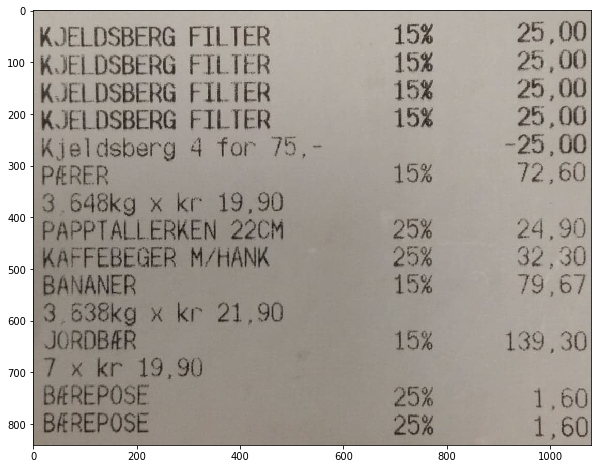

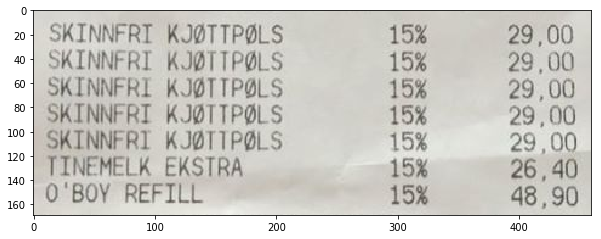

In [11]:
RECEIPT_PAHT = 'receipts'
for receipt in [a for a in os.listdir(RECEIPT_PAHT) if a.split('.')[-1] in ('jpg', 'jpeg', 'png')]:
    path = os.path.join(RECEIPT_PAHT, receipt)
    fig, ax = plt.subplots(figsize=(10, 10))
    plt.imshow(Image.open(path))
    output = predict_image(path)
    new_out = '\n'.join([' '.join([check_word(w) for w in line.split(' ')]) for line in output.split('\n')])
    print(output)
    print(new_out)
    print()